# Exploring the Android App Market - A Data Mining Analysis of Google Playstore Applications 



SENG 474 Fall 2018 Data Mining Project<br>
Cole Boothman St.ID V00808231 <br>
Amy Hanvoravongchai V00822271 <br>

Using the Naive Bayes text classification algorithm, an analysis of user reviews was made based on the sentiment rating given to each review. 
<br>
This data file contains the first 'most relevant' 100 reviews for each app. Each review text or comment has been pre-processed and attributed with 3 new features: Sentiment, Sentiment Polarity, and Sentiment Subjectivity.
The user reviews data for application of the Google Playstore has a total of 37427 entries.

The first thing we need to do is load our data file. The data is in CSV format without a header line or any quotes. We can open the file with the open function and read the data lines using the reader function in the CSV module.

In [1]:
import pandas as pd
import random
import re

# Read the data from a file
data = pd.read_csv('googleplaystore_user_reviews.csv', encoding = "ISO-8859-1")
data = data.iloc[:, 1:]
data.head()

,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,NaN,NaN,NaN,NaN
3,Works great especially going grocery store,Positive,0.40,0.875000
4,Best idea us,Positive,1.00,0.300000


In [2]:
data = data[pd.notnull(data['Translated_Review'])]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37427 entries, 0 to 64230
Data columns (total 4 columns):
Translated_Review         37427 non-null object
Sentiment                 37427 non-null object
Sentiment_Polarity        37427 non-null float64
Sentiment_Subjectivity    37427 non-null float64
dtypes: float64(2), object(2)
memory usage: 1.4+ MB


In the figure below, is a graphic for the reviews grouped by their sentiment value. Positive value seems to be highest, by far, and neutral as lowest. 

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
data.groupby('Sentiment').Translated_Review.count().plot.barh(ylim=0)
plt.show()

<Figure size 800x600 with 1 Axes>

We want to convert obtained dataframe into list. It filters out irrelevant columns not used in this document. We are ignoring capitalizations and NaNs.
<br> 
Corresponding sentiment values as integers:
<br>
<ul>
    <li> 'Positive' as 0 </li>
    <li> 'Neutral' as 1 </li>
    <li> 'Negative' as 2 </li>
</ul>

In [4]:
def get_data(data):

    #change dataframe to lists
    reviews = data.iloc[:,0].dropna().tolist()
    sentiment = data.iloc[:,1].dropna().tolist()
    
    #changing sentiment ()list values to int values
    for index, item in enumerate(sentiment):
        if item == 'Positive':
            sentiment[index] = 0
        elif item == 'Neutral':
            sentiment[index] = 1
        else:
            sentiment[index] = 2
    return reviews, sentiment

The training model performs the following text preprocessing: 
<br>
<ul>
    <li>removes capitalization, </li>
    <li>removes non-alphabetical symbols (a-z only), </li>
    <li>removes stop words (utlizing nltk.corpus), </li>
    <li>sets a minimum count (text frequency) for occurences of a word to higher than three </li>
</ul>
With these preprocessing filters for the reviews, a high accuracy for the text classification can better be achieved.


In [5]:
model = {}
from nltk.corpus import stopwords 

def train_model(data, sentiment):
    stop_words = set(stopwords.words('english'))
    sum_words_positive = 0
    sum_words_negative = 0
    sum_words_neutral = 0
    positive_count = 0
    negative_count = 0
    neutral_count = 0
    
    reviews = [[y.lower() for y in x.split()]for x in data] 
    for i, review in enumerate(reviews):
        reviews[i] = [word for word in review if word not in stop_words]
    count_of_words = {}         
    for i, sentence in enumerate(reviews):
        for word in sentence:
            word = re.sub(r'[^a-z]', '', word)
            if word not in model:
                model[word] = [0, 0, 0] 
            #already encountered word
            model[word][sentiment[i]] += 1
            if word not in count_of_words:
                count_of_words[word] = 1
            else:
                count_of_words[word] += 1

        for word, count in count_of_words.items():
            if count < 3 and word in model:
                model.pop(word)
        if sentiment[i] == 0:
            sum_words_positive += len(sentence)
            positive_count += 1
        elif sentiment[i] == 1:
            sum_words_neutral += len(sentence)
            neutral_count += 1
        elif sentiment[i] == 2:
            sum_words_negative += len(sentence)
            negative_count += 1
        else:
            continue
    
    return model, positive_count, negative_count, neutral_count, sum_words_positive, sum_words_negative, sum_words_neutral

A partition of the data set is split for train set and test set <b>randomly</b>.
<br>
Train data is 80% of the dataset. 
<br>
Test data is 20% of the dataset.
<br>
It is important that the data be partitioned into these two subsets so that the train data set can decide upon the accuracy of the classifier more effectively. We want to randomize the partition so that it is a unique training and test set each time the classifier runs. 


In [6]:
train_data = data.sample(frac=0.8)
test_data = data.drop(train_data.index)
    
train_data, train_sentiment = get_data(train_data)
train_model_dict, positive_count, negative_count, neutral_count, sum_words_positive, sum_words_negative, sum_words_neutral = train_model(train_data,train_sentiment)
test_data, test_sentiment = get_data(test_data)

The probability is calculated below. 

Probabilities: 
Positive: 0.6413065259501703
Neutral: 0.13756596085765813
Negative:  0.22112751319217153


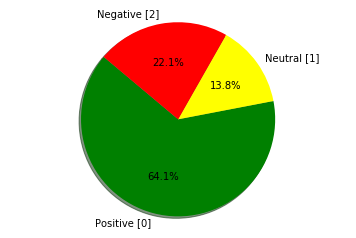

In [7]:
total = positive_count + negative_count + neutral_count
probability_positive = positive_count/total
probability_negative = negative_count/total
probability_neutral = neutral_count/total

print ("Probabilities: \n" + "Positive: " + str(probability_positive) + "\nNeutral: "+ str(probability_neutral) + "\nNegative:  " + str(probability_negative) )

# Data to plot
labels = 'Positive [0]', 'Neutral [1]', 'Negative [2]'
sizes = [probability_positive, probability_neutral, probability_negative]
colors = ['green', 'yellow', 'red']
 
# Plot
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

To avoid the zero frequency problem we do: 
![alpha.png](alpha.png)
We create a list with its index representing the 0, 1, 2 sentiment values, as previously mentioned.

In [8]:
def calc_cond_probabilities(train_model_dict, positive_count, negative_count, neutral_count, sum_words_positive, sum_words_negative, sum_words_neutral):
    cond_probabilities = {}

    for word in model:
      
        if word not in cond_probabilities:
            cond_probabilities[word] = [0, 0, 0]

        #calculate conditional probabilities
        cond_probabilities[word][0] = (model[word][0] + 1)/(sum_words_positive + len(model))
        cond_probabilities[word][1] = (model[word][1] + 1)/(sum_words_neutral + len(model))
        cond_probabilities[word][2] = (model[word][2] + 1)/(sum_words_negative + len(model))

    return cond_probabilities

conditional_probabilities = {}
conditional_probabilities = calc_cond_probabilities(train_model_dict, positive_count, negative_count, neutral_count, sum_words_positive, sum_words_negative, sum_words_neutral)

To avoid number overflow, we operate on the logs of probabilities on our data below:
![log.png](log.png)

In [9]:
import math

def classify_test_data(words, probablility_positive, probablility_negative, probablility_neutral, conditional_probabilities):
    positive = 1
    negative = 1
    neutral = 1
    for word in words:
        if word in model:
            positive += math.log2(conditional_probabilities[word][0])
            neutral += math.log2(conditional_probabilities[word][1])
            negative += math.log2(conditional_probabilities[word][2])

    positive += math.log2(probability_positive)
    negative += math.log2(probability_negative)
    neutral += math.log2(probability_neutral)

    if (positive > negative) and (positive > neutral):
        return 0
    elif (neutral > positive) and (neutral > negative):
        return 1
    else:
        return 2

In [10]:
result = []
for i, element in enumerate(test_data):
    words = element.split(' ')
    result.append(classify_test_data(words, probability_positive, probability_negative, probability_neutral, conditional_probabilities))


correct = 0
incorrect = 0

for i, j in zip(result, test_sentiment):

    if i == j:
        correct += 1
    else:
        incorrect += 1

print("Accuracy: " + str((correct/len(test_sentiment))*100))

Accuracy: 73.14629258517033


-------------------------------------------

The accuracy can be tested with SKlearn's Naive Bayes MultinomialNB module. It implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification. We want to compare the effectiveness of the Naive Bayes algorithm above with the result of SKlearn's.

In [11]:
import pylab

In [12]:
col = ['Sentiment', 'Translated_Review']
df = pd.read_csv('googleplaystore_user_reviews.csv', encoding = "ISO-8859-1")
df = df[pd.notnull(df['Translated_Review'])]
df = df[col]
df.columns = ['Sentiment', 'Translated_Review']
df.columns

Index(['Sentiment', 'Translated_Review'], dtype='object')

For this project, we need only two columns — “Sentiment” and “Translated_Review”.
We will remove missing values in “Translated_Review” column, and add a column encoding the product as an integer because categorical variables are often better represented by integers than strings.
We also create a couple of dictionaries for future use.

In [13]:
df['sentiment_id'] = df['Sentiment'].factorize()[0]
sentiment_id_df = df[['Sentiment', 'sentiment_id']].drop_duplicates().sort_values('sentiment_id')
sentiment_to_id = dict(sentiment_id_df.values)
id_to_sentiment = dict(sentiment_id_df[['sentiment_id', 'Sentiment']].values)
df.head()

,Sentiment,Translated_Review,sentiment_id
0,Positive,I like eat delicious food. That's I'm cooking ...,0
1,Positive,This help eating healthy exercise regular basis,0
3,Positive,Works great especially going grocery store,0
4,Positive,Best idea us,0
5,Positive,Best way,0


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Translated_Review'], df['Sentiment'])
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)
from sklearn import metrics

# (clf.predict(count_vect.transform(["great app."])))
y_pred = clf.predict(count_vect.transform(X_test))
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Sentiment'].unique()))
print("Accuracy: "+ str(metrics.accuracy_score(y_test, y_pred)*100))

              precision    recall  f1-score   support

    Positive       0.85      0.39      0.54      2038
     Neutral       0.95      0.06      0.12      1237
    Negative       0.72      0.99      0.84      6082

   micro avg       0.74      0.74      0.74      9357
   macro avg       0.84      0.48      0.50      9357
weighted avg       0.78      0.74      0.68      9357

Accuracy: 73.7629582131025


--------------------

<h3>Conclusion</h3> <br>
We can conclude that the text classification on this data is with 72 to 74 per cent accuracy.